# 3D Localization example with cubic splines

## Installing

* Download anaconda 64 bit (only windows support atm) and install. 
* Make sure CUDA Toolkit >= 10.1 is installed.
* Open the anaconda prompt and create a python 3.7 environment:

```
conda create -n mytestenv python=3.7
conda activate mytestenv
```

* Install jupyterlab so you can run this notebook:
`conda install -c conda-forge jupyterlab`

* Install photonpy using: 
`pip install photonpy`

* Change directory to whatever folder you put the notebook in and run jupyter lab: `jupyter lab`

## Summary

This example goes through the following steps:
1. Load a cubic spline PSF model
2. Simulate a STORM acquisition with blinking molecules in a cylinder shape
3. Set up the spot detection pipeline to detect ROIs from the movie
4. Run MLE localization on the resulting ROIs.
5. Filter results using a chi-square threshold, and plot the results

First, import all the necessary python modules and load the photonpy C++ DLL by creating a Context object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from photonpy.cpp.context import Context
from photonpy.smlm.psf import psf_to_zstack
import math
import time

ctx = Context()

## Loading the PSF calibration

Load the PSF model stored in a .MAT file, generated by the nature paper ([Real-time 3D single-molecule localization using experimental point spread functions](https://www.nature.com/articles/nmeth.4661) ).

(200, 32, 32, 64)
Z min=-1.0, max=0.995
Voxels X:32, Y:32, Z:200
Estimator parameters: x,y,z,I,bg


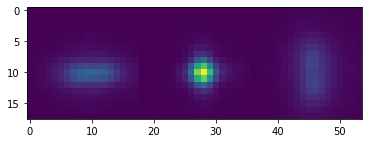

In [2]:
roisize = 18
cspline_fn = 'cspline-nm-astig.mat'
import os
if not os.path.exists(cspline_fn):
    import urllib.request
    url=f'http://homepage.tudelft.nl/f04a3/{cspline_fn}'
    print(f"Downloading {url}")
    urllib.request.urlretrieve(url, cspline_fn)
    
from photonpy.cpp.cspline import CSpline_Calibration, CSpline
cspline_calib = CSpline_Calibration.from_file_nmeth(cspline_fn)      # Load the calibration data from the .MAT file
psf = CSpline(ctx).CreatePSF_XYZIBg(roisize, cspline_calib, cuda=True)    # Create a cubic spline PSF estimator object with specific ROI size.
print(f"Estimator parameters: {psf.ParamFormat()}")

from photonpy.smlm.util import imshow_hstack
imshow_hstack(psf_to_zstack(psf, [-0.5, 0, 0.5]));


## STORM Simulation
Generate a movie from the given set of emitter positions. There is no simulation of emitter on-times, just per frame probability of being photoactivated.

In [3]:
def generate_storm_movie(psf, xyzI, numframes, imgsize, bg, p_on):
    
    frames = np.zeros((numframes, imgsize, imgsize), dtype=np.float32)
    on_counts = np.zeros(numframes, dtype=np.int32)

    for f in range(numframes):
        on = np.random.binomial(1, p_on, len(xyzI))

        roisize = psf.sampleshape[0]
        roipos = np.clip((xyzI[:,[1,0]] - roisize/2).astype(int), 0, imgsize-roisize)
        theta = np.zeros((len(xyzI),5)) # assuming xyzIb
        theta[:,0:4] = xyzI
        theta[:,[1,0]] -= roipos
        on_spots = np.nonzero(on)[0]

        rois = psf.ExpectedValue(theta[on_spots])
        
        frames[f] = ctx.smlm.DrawROIs((imgsize,imgsize), rois, roipos[on_spots])
        frames[f] += bg
        on_counts[f] = np.sum(on)

    return frames, on_counts

Generate a list of emitter positions in a cylinder shape:

In [4]:
N = 500
object_size_um = 1 #um
img_width = 64
pixelsize = 0.1 #um/pixel
emitter_intensity = 1000

angle = np.random.uniform(0, 2 * math.pi, N)
xyzI = np.zeros((N,4))
xyzI[:,0] = object_size_um/2 / pixelsize * np.cos(angle) + img_width / 2
xyzI[:,1] = np.linspace(0.2,0.8,N) * img_width
xyzI[:,2] = np.sin(angle) * object_size_um/2
xyzI[:,3] = emitter_intensity

Generate the movie frames. p_on is chosen such that on average 2 emitters are in on state

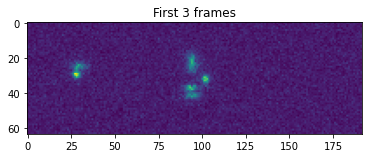

In [5]:
mov_expval, on_counts = generate_storm_movie(psf, xyzI, numframes=1000, 
                                      imgsize=img_width,bg=5, p_on=2 / len(xyzI)) 

mov = np.random.poisson(mov_expval)

plt.figure();
plt.imshow(np.concatenate(mov[:3],-1));
plt.title('First 3 frames');


# Spot detection and ROI extraction

Using a C++-side queue, image processing is done multithreaded and very fast:


In [6]:
from photonpy.cpp.spotdetect import PSFConvSpotDetector, SpotDetectionMethods

def extract_rois(mov, spotDetector, roisize):
    imgshape = mov[0].shape
    roishape = [roisize,roisize]

    img_queue, roi_queue = SpotDetectionMethods(ctx).CreateQueue(imgshape, roishape, spotDetector)

    t0 = time.time()

    for img in mov:
        img_queue.PushFrame(img)

    while img_queue.NumFinishedFrames() < len(mov):
        time.sleep(0.1)

    dt = time.time() - t0
    print(f"Processed {len(mov)} frames in {dt:.2f} seconds. {len(mov)/dt:.1f} fps")

    rois, data = roi_queue.Fetch()
    roipos = np.array([rois['x'],rois['y'],rois['z']]).T
    return roipos, data, rois['id']

psf_zrange = np.linspace(-0.6, 0.6, 100)
psfstack = psf_to_zstack(psf, psf_zrange)

backgroundImage = np.zeros(mov[0].shape)

# this sets up the template-based spot detector. MinPhotons is not actually photons, still just AU.
sd = PSFConvSpotDetector(psfstack, backgroundImage, minPhotons=10, maxFilterSizeXY=5, debugMode=False)
roipos, rois, framenum = extract_rois(mov, sd, roisize)

imshow_hstack(rois, title='First 10 ROIs');

ImportError: cannot import name 'PSFConvSpotDetector' from 'photonpy.cpp.spotdetect' (c:\dev\photonpy\photonpy\cpp\spotdetect.py)

The spot detector is applying a convolution of the PSF at different Z positions, and as a result also provides initial values for further localization. 

We can now plot the spot detector Z coordinates:

In [ ]:
plt.figure()
hist = np.histogram(roipos[:,2],bins=len(psf_zrange),range=[0,len(psf_zrange)])
plt.bar(psf_zrange, hist[0], width=(psf_zrange[-1]-psf_zrange[0])/len(hist[0]))
plt.xlabel('Z position [um]')
plt.title('Z position initial estimate from PSF convolutions');

# Localization

Run the cubic spline maximum likelihood estimation on each extracted ROI:

In [ ]:
def result_scatterplot(results, roipos_):
    results = results*1 # make a copy so we can adjust it
    results[:,[0,1]] += roipos_[:,[0,1]]  # Add the ROI positions to get back to full image positions for each emitter

    plt.figure()    
    plt.scatter(results[:,0]*pixelsize, results[:,2],s=1.5, label='Estimated')
    plt.scatter(xyzI[:,0]*pixelsize, xyzI[:,2], s=1,label='Ground truth')
    plt.xlabel('X [microns]'); plt.ylabel('Z [microns]')
    plt.xlim([img_width*0.5*pixelsize-object_size_um*0.6, img_width*0.5*pixelsize+object_size_um*0.6])
    plt.ylim([-object_size_um*0.7,object_size_um*0.7])
    plt.legend()
    print(f"#spots: {len(results)}")


initial_guess = np.ones((len(rois), 5)) * [roisize/2,roisize/2,0,0,1]
initial_guess[:,2] = psf_zrange[roipos[:,2]]
initial_guess[:,3] = np.sum(rois,(1,2)) * 0.5 # Assume half the photons are emitter photons

estim = psf.Estimate(rois, initial=initial_guess)[0]

result_scatterplot(estim, roipos);
plt.title(f'X-Z section [{len(estim)} spots] (Unfiltered)');


# Chi-Square filtering

Calculate the chi-square value for each spot, which is an indication of how well the model represents the samples in the ROI. 

In [ ]:
expval = psf.ExpectedValue(estim)
chisq = np.sum( (rois-expval)**2 / (expval+1e-9), (1,2))

std_chisq = np.sqrt(2*psf.samplecount + np.sum(1/np.mean(expval,0)))

# Filter out all spots that have a chi-square > expected value + 2 * std.ev.
chisq_threshold = psf.samplecount + 2*std_chisq
sel = chisq < chisq_threshold
print(f"Chi-Square threshold: {chisq_threshold:.1f}. Removing {np.sum(sel==False)}/{len(rois)} spots")

plt.figure()
plt.hist(chisq,bins=100,range=[0,1000])
plt.gca().axvline(chisq_threshold,color='r', label='threshold')
plt.title('Chi-Square values for each localization')
plt.legend()

result_scatterplot(estim[sel], roipos[sel])

# File export

Final results can be written to Picasso HDF5 format for further analysis.

In [ ]:
import photonpy.smlm.picasso_hdf5 as picasso

results = estim[sel]
crlb = psf.CRLB(results)
results[:,[0,1]] += roipos[sel][:,[0,1]]  # Add the ROI positions to get back to full image positions for each emitter

# Note that sigmax,y are just arbitrary values, since we are using a cubic spline model we don't know these.
picasso.save('cubic-spline-simulation-results.hdf5', results, crlb, framenum[sel], mov[0].shape, sigmaX=2, sigmaY=2)